In [4]:
###########This is a custom function file containing data preprocessing functions######
import inspect
import os

import numpy as np 
import pandas as pd 

from datetime import date, timedelta
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import LabelEncoder
# import lightgbm as lgb

#
def find_min_max_daterange(df):
    """
    This function takes a DataFrame with a column named 'date' and returns the minimum
    and maximum dates found in that column.

    Parameters:
    df (pandas.DataFrame): A DataFrame containing a 'date' column with datetime objects.

    Returns:
    tuple: A tuple containing two elements:
        - min_date (datetime)
        - max_date (datetime) 
    """
    min_date = df['date'].min()
    max_date = df['date'].max()
#     print(f'date range is from  ,{min_date,max_date}')
    return min_date,max_date

def filter_dataframe(df,date):
    """
    Filter a DataFrame for rows with dates greater than or equal to the given date.

    Parameters:
    df (pandas.DataFrame): The input DataFrame with a 'date' column.
    date (datetime): The date to filter the DataFrame by.

    Returns:
    pandas.DataFrame: The filtered DataFrame.
    """
    
    df_filtered = df.loc[df.date>=date]
    return df_filtered


def promotion_data_preprocessing (promo_data) :
    """
    Fill missing 'onpromotion' values with 0 in the promotion data.

    Parameters:
    promo_data (pandas.DataFrame): The DataFrame containing promotion data.

    Returns:
    pandas.DataFrame: The DataFrame with missing 'onpromotion' values filled.
    """
    
    promo_data.fillna({'onpromotion': 0 }, inplace=True)
#     promo_data['onpromotion'].fillna(0, inplace=True)
    return promo_data
    


def oil_data_preprocessing(df, oil_df):
    
    """
    Merge and preprocess oil price data into the main DataFrame.

    This function merges oil price data with the main DataFrame on the 'date' column,
    imputes missing oil prices with the average price for the corresponding year-month,
    and removes temporary columns used for the imputation.

    Parameters:
    df (pandas.DataFrame): The main DataFrame containing the data to be merged.
    oil_df (pandas.DataFrame): The DataFrame containing oil price data.

    Returns:
    pandas.DataFrame: The merged and preprocessed DataFrame.
    """
    import pandas as pd
    df = pd.merge(df, oil_df, how='left', on=['date'])
    # there are missing values in dcoilwtico (oil price).  Let's imputed it using average for the month-year combo
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    oil_df['year'] = oil_df['date'].dt.year
    oil_df['month'] = oil_df['date'].dt.month

    dcoilwtico_mean = oil_df.groupby(['year', 'month'], as_index=False)[['dcoilwtico']].mean()
    dcoilwtico_mean = dcoilwtico_mean.rename(columns = {'dcoilwtico':'dcoilwtico_mean'})
    

    # Replace missing dcoilwtico (oil price) with average dcoilwtico imputed above
    df = pd.merge(df, dcoilwtico_mean, how='left', on=['year', 'month'])
    df.fillna({'dcoilwtico': df['dcoilwtico_mean']}, inplace=True)
#     df['dcoilwtico'].fillna(df['dcoilwtico_mean'], inplace=True)
    df.drop('dcoilwtico_mean', axis=1, inplace=True)
    df.drop(['year', 'month'], axis=1, inplace=True)
    oil_df.drop(['year', 'month'], axis=1, inplace=True)

    df.columns[df.isnull().any()]   # these columns have missing values
    
    return df 
    

def transaction_data_preprocessing(df,trans_df):
    """
    Preprocess transaction data and merge it with the main DataFrame.

    This function sets the index of the transaction DataFrame to ['store_nbr', 'date'],
    joins it with the main DataFrame, and fills missing transaction values with 0.

    Parameters:
    df (pandas.DataFrame): The main DataFrame to which transaction data will be added.
    trans_df (pandas.DataFrame): The DataFrame containing transaction data.

    Returns:
    pandas.DataFrame: The merged DataFrame with transaction data included.
    """
    trans_df = trans_df.set_index(["store_nbr", "date"])[["transactions"]]
    # Join the two DataFrames
    df = df.join(trans_df, how='left')
#     df.columns[df.isnull().any()]   # these columns have missing values
#     df['transactions'].fillna(0, inplace=True)
    df.fillna({'transactions': 0}, inplace=True)
    return df
   

def create_date_features(df):
    """
    Extract date-related features from the 'date' column in the DataFrame.

    - 'day_of_week': Day of the week (0=Monday, 6=Sunday).
    - 'month': Month of the year.
    - 'day': Day of the month.
    - 'week': ISO week number.
    - 'year': Year.
    - 'is_weekend': Boolean indicating if the date is a weekend.
    - 'Dayofyear': Day of the year.

    Parameters:
    df (pandas.DataFrame): The input DataFrame with a 'date' column.

    Returns:
    pandas.DataFrame: The DataFrame with new date-related features.
    """
        #Extract date-related features

    df['day_of_week'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['week'] = df['date'].dt.isocalendar().week
    df['year'] = df['date'].dt.year
    df['is_weekend'] = df['date'].dt.dayofweek >= 5
    df['Dayofyear'] = df['date'].dt.dayofyear
        
    return df
    
    
def create_holiday_features (df,hol_df):
    """
    Add holiday features to the DataFrame based on the holiday information.

    This function merges holiday data into the main DataFrame, categorizes holidays
    by their locale (city, state, national), and imputes missing values for holiday types 
    and descriptions.

    Parameters:
    df (pandas.DataFrame): The main DataFrame to which holiday data will be added.
    hol_df (pandas.DataFrame): The DataFrame containing holiday information.

    Returns:
    pandas.DataFrame: The DataFrame with holiday features added.
    """
    

    hol_df.drop(hol_df[hol_df.transferred == True].index, inplace=True)
        # Break holidays into separate dataframes
    holidays_cities = hol_df[hol_df.locale == "Local"]       # city level holidays
    holidays_states = hol_df[hol_df.locale == "Regional"]    # state level holidays
    holidays_national = hol_df[hol_df.locale == "National"]  # national holidays

        # # Rename columns to help with joining dataframes later
    holidays_cities = holidays_cities.rename(columns = {'locale_name':'city', 'type':'holiday_type'})
    holidays_states = holidays_states.rename(columns = {'locale_name':'state', 'type':'holiday_type'})
    holidays_national = holidays_national.rename(columns = {'type':'holiday_type'})
        # # We don't need locale_name at all for national holidays
    holidays_national.drop('locale_name', axis=1, inplace=True)
        
        # # locale column is useless - let's drop it to simplify joining dataframes
    holidays_cities.drop('locale', axis=1, inplace=True)
    holidays_states.drop('locale', axis=1, inplace=True)
    holidays_national.drop('locale', axis=1, inplace=True)

        # # transferred column is now useless - let's drop it to simplify joining dataframes
    holidays_cities.drop('transferred', axis=1, inplace=True)
    holidays_states.drop('transferred', axis=1, inplace=True)
    holidays_national.drop('transferred', axis=1, inplace=True)
        
        
    df = pd.merge(df, holidays_cities, how='left', on=['date', 'city'])
#         df.columns[df.isnull().any()]   # these columns have missing values
    df = df.rename(columns = {'holiday_type':'holiday_type_city', 'description':'description_city'})


    df = pd.merge(df, holidays_states, how='left', on=['date', 'state'])
#         df.columns[df.isnull().any()]   # these columns have missing values
    df = df.rename(columns = {'holiday_type':'holiday_type_state', 'description':'description_state'})

    df = pd.merge(df, holidays_national, how='left', on=['date'])
#         df.columns[df.isnull().any()]   # these columns have missing values
    df.rename(columns = {'holiday_type':'holiday_type_nat', 'description':'description_nat'}, inplace=True)

        # Impute missing values
    df.fillna({'holiday_type_city': 'no holiday'}, inplace=True)
    df.fillna({'holiday_type_state': 'no holiday'}, inplace=True)
    df.fillna({'holiday_type_nat': 'no holiday'}, inplace=True)
    df.fillna({'description_city': 'no holiday'}, inplace=True)
    df.fillna({'description_state': 'no holiday'}, inplace=True)
    df.fillna({'description_nat': 'no holiday'}, inplace=True)
    

#         df.columns[df.isnull().any()]   # these columns have missing values
        
    return df
    
    
def create_paydate_feature(df):
    """
    Add a 'PayDay' feature to the DataFrame based on mid-month and end-of-month paydays.

    This function identifies the 15th day and the last day of each month as paydays and adds
    a binary 'PayDay' column to the DataFrame, where 1 indicates a payday and 0 otherwise.

    Parameters:
    df (pandas.DataFrame): The input DataFrame with 'date', 'day', and 'Dayofyear' columns.

    Returns:
    pandas.DataFrame: The DataFrame with the 'PayDay' feature added.
    """
        
        # Get mid-month paydays
    mid_month = df['Dayofyear'][df['day'] == 15].unique()

        # Get end-of-month paydays
    end_month = df['Dayofyear'][df['date'].dt.is_month_end].unique()

        # Combine mid-month and end-of-month paydays
    paydates = np.append(mid_month, end_month)
    paydates

        #Adding pay days data  
    df['PayDay'] = np.where(np.isin(df.Dayofyear, paydates), 1, 0)

    df.Dayofyear[df.PayDay == 1].unique()

    return df

    
def custom_label_encoding(df):
    """
    Perform custom label encoding for categorical columns in the DataFrame.

    This function encodes specific categorical columns in the DataFrame using custom dictionaries.

    Parameters:
    df (pandas.DataFrame): The input DataFrame with categorical columns to be encoded.

    Returns:
    pandas.DataFrame: The DataFrame with encoded categorical columns.
    """
        
    data = ['Quito', 'Guayaquil', 'Cuenca', 'Santo Domingo', 'Ambato', 'Machala', 'Manta', 'Latacunga',
             'Loja', 'Daule', 'Cayambe', 'Babahoyo', 'Esmeraldas', 'Libertad', 'Salinas', 'Ibarra',
             'Quevedo', 'Guaranda', 'Puyo', 'Riobamba', 'El Carmen', 'Playas']

        # Create a dictionary to map each city to its index
    mapping = {a: i for i, a in enumerate(data)}
    df['city'] = df['city'].map(mapping)


    data = ['Pichincha', 'Guayas', 'Azuay', 'Santo Domingo de los Tsachilas', 'Tungurahua', 'Manabi', 'El Oro',
                         'Los Rios', 'Cotopaxi', 'Loja', 'Esmeraldas', 'Santa Elena', 'Imbabura', 'Bolivar', 'Pastaza', 'Chimborazo']

        # Create a dictionary to map each city to its index
    mapping = {a: i for i, a in enumerate(data)}
    df['state'] = df['state'].map(mapping)

    data = ['A','B','C','D','E']

    # Create a dictionary to map each city to its index
    mapping = {a: i for i, a in enumerate(data)}
    df['type'] = df['type'].map(mapping)


    data = ['GROCERY I', 'BEVERAGES', 'CLEANING', 'PRODUCE', 'DAIRY', 'PERSONAL CARE', 'BREAD/BAKERY',
                         'HOME CARE', 'DELI', 'MEATS', 'POULTRY', 'FROZEN FOODS', 'EGGS', 'LIQUOR,WINE,BEER', 
                         'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'PREPARED FOODS', 'CELEBRATION', 
                         'PLAYERS AND ELECTRONICS', 'LADIESWEAR', 'LAWN AND GARDEN', 'AUTOMOTIVE', 'PET SUPPLIES', 
                         'GROCERY II', 'LINGERIE', 'SEAFOOD', 'BEAUTY', 'MAGAZINES', 'SCHOOL AND OFFICE SUPPLIES', 
                         'HARDWARE', 'HOME APPLIANCES', 'BABY CARE', 'BOOKS']

        # Create a dictionary to map each city to its index
    mapping = {a: i for i, a in enumerate(data)}
    df['family'] = df['family'].map(mapping)

    data = ['no holiday', 'Holiday', 'Transfer', 'Additional', 'Event']
        # Create a dictionary to map each city to its index
    mapping = {a: i for i, a in enumerate(data)}
    df['holiday_type_city'] = df['holiday_type_city'].map(mapping)
    df['holiday_type_state'] = df['holiday_type_state'].map(mapping)
    df['holiday_type_nat'] = df['holiday_type_nat'].map(mapping)

    data = ['no holiday', 'Fundacion de Guayaquil-1',
                'Fundacion de Guayaquil',
                'Fundacion de Cuenca', 
                'Fundacion de Santo Domingo',
                'Fundacion de Machala',
                'Cantonizacion de Latacunga',
                        'Cantonizacion de Cayambe',
                'Fundacion de Manta', 'Cantonizacion de Libertad','Fundacion de Esmeraldas',
                'Cantonizacion de Riobamba',
                        'Fundacion de Riobamba',
                'Cantonizacion de Guaranda', 'Cantonizacion del Puyo', 
                'Cantonizacion de El Carmen',
                'Provincializacion de Cotopaxi',
                        'Provincializacion de Imbabura', 'Carnaval', 'Dia del Trabajo', 'Dia de la Madre-1',
                        'Traslado Primer dia del ano', 'Traslado Batalla de Pichincha', 'Dia de la Madre',
                        'Traslado Primer Grito de Independencia','Viernes Santo']

        # Create a dictionary to map each city to its index
    mapping = {a: i for i, a in enumerate(data)}
    df['description_city'] = df['description_city'].map(mapping)
    df['description_state'] = df['description_state'].map(mapping)
    df['description_nat'] = df['description_nat'].map(mapping)
        
        
    return df
    
    
def filter_dataframe_training_validation(df,start,end):
    """
    Filter the DataFrame for a specified date range for training and validation.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing date information.
    start (datetime): The start date of the range (inclusive).
    end (datetime): The end date of the range (inclusive).

    Returns:
    pandas.DataFrame: The filtered DataFrame containing data within the specified date range.
    """

# Assuming your DataFrame is named df
    filtered_df = df[(df['date'] >= start) & (df['date'] <= end)]
    return filtered_df

def find_feature_importance(train_df):
    """
    This function calculates feature importance using a trained model, creates a DataFrame
    for visualization, and plots the feature importances in a horizontal bar plot.

    Parameters:
    train_df (pandas.DataFrame): The DataFrame containing training data features.

    Returns:
    None
    """
    
    # Calculate feature importance
    feature_importances = model.get_feature_importance()
    feature_names = train_df.columns

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    })

    # Sort the DataFrame by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()
    

def calculate_score(pred, act, weight, chunk_size=1000):
    """
    Calculate the Normalized Weighted Root Mean Squared Logarithmic Error (NWRMSLE).

    Parameters:
    pred (array-like): Predicted values.
    act (array-like): Actual values.
    weight (array-like): Weight for each data point.
    chunk_size (int): Size of the chunks for processing data.

    Returns:
    float: The calculated NWRMSLE score.
    """
    # Convert pred and act to numpy arrays
    pred =  (np.array(pred)).T
    act = np.array(act)
    per_weight = np.array(weight)
    # Calculate the number of chunks
    num_chunks = int(np.ceil(len(pred) / chunk_size))
    
    # Initialize total nwrmsle
    total_nwrmsle = 0
    
    # Process data in chunks
    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(pred))
        
        # Get chunk of data
        chunk_pred = pred[start_idx:end_idx]
        chunk_act = act[start_idx:end_idx]
        
        # Calculate nwrmsle for chunk
        chunk_nwrmsle = np.sum(per_weight[start_idx:end_idx] * np.square(chunk_pred - chunk_act))
        
        # Add chunk nwrmsle to total
        total_nwrmsle += chunk_nwrmsle
    
    # Calculate final nwrmsle
    nwrmsle = math.sqrt(total_nwrmsle / np.sum(per_weight))
    
    return nwrmsle


    
    
    
    
    
    
    
    
    
# function to write the definition of our function to the file
def write_function_to_file(function, file):
    if os.path.exists(file):
        append_write = 'a' # append if already exists
    else:
        append_write = 'w' # make a new file if not
    with open(file, append_write) as file:
        function_definition = inspect.getsource(function)
        file.write(function_definition)

# write both of our functions to our output file        
write_function_to_file(find_min_max_daterange, "custom_functions.py")
write_function_to_file(filter_dataframe, "custom_functions.py")
write_function_to_file(promotion_data_preprocessing, "custom_functions.py")
write_function_to_file(oil_data_preprocessing, "custom_functions.py")
write_function_to_file(transaction_data_preprocessing, "custom_functions.py")
write_function_to_file(create_date_features, "custom_functions.py")
write_function_to_file(create_holiday_features, "custom_functions.py")
write_function_to_file(create_paydate_feature, "custom_functions.py")
write_function_to_file(custom_label_encoding, "custom_functions.py")
write_function_to_file(filter_dataframe_training_validation, "custom_functions.py")
write_function_to_file(find_feature_importance, "custom_functions.py")
write_function_to_file(calculate_score, "custom_functions.py")

# ****Data Preprocessing and Modelling ****

****Reading input data****

In [5]:
from shutil import copyfile
import pandas as pd
# from custom_functions import *  #uncomment to load functions from custom_functions.py

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
!pip install pyunpack
!pip install patool
os.system('apt-get install p7zip')
from pyunpack import Archive
import shutil
from catboost import CatBoostRegressor
import joblib 


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        Archive(os.path.join(dirname, filename)).extractall('/kaggle/working/')
        print(os.path.join(dirname, filename))
        
##Read input data

#reading training data
chunk_size=100000
train_csv_file_path = './train.csv'
# optimize memory loading by specifying the data types...
# dtype = {'id':'uint32', 'item_nbr':'int32', 'store_nbr':'int8', 'onpromotion':bool}
chunks = pd.read_csv(train_csv_file_path, usecols=[1, 2, 3, 4, 5] ,
                     parse_dates=["date"],
                     converters={'unit_sales': lambda u: np.log1p(
        float(u)) if float(u) > 0 else 0 },
                     chunksize=chunk_size)
lst=[]
for chunk in chunks:
#     chunk['returned'] = chunk['unit_sales'].apply(lambda u: 1 if u < 0 else 0)
    lst.append(chunk)
train_data = pd.concat(lst, ignore_index=True)
del lst
print("training data is loaded")
print(train_data.shape)



#reading item data test data has item_nbr|family|class|perishable
item_csv_file_path = './items.csv'
item_data = pd.read_csv(item_csv_file_path).set_index("item_nbr")
print("item data is loaded")
print(item_data.shape)

#reading store data test data has store_nbr|city|state|type|cluster
store_csv_file_path = './stores.csv'
store_data = pd.read_csv(store_csv_file_path).set_index("store_nbr")
print("store data is loaded")
print(store_data.shape)

#reading oil data test data has store_nbr|city|state|type|cluster
oil_csv_file_path = './oil.csv'
oil_data = pd.read_csv(oil_csv_file_path ,parse_dates=["date"],)
print("oil data is loaded")
print(oil_data.shape)


#reading transaction data test data has store_nbr|city|state|type|cluster
transaction_csv_file_path = './transactions.csv'
trans_data = pd.read_csv(transaction_csv_file_path, parse_dates=["date"],)
print("oil data is loaded")
print(trans_data.shape)

#reading holiday data test data has store_nbr|city|state|type|cluster
holiday_csv_file_path = './holidays_events.csv'
hol_data = pd.read_csv(holiday_csv_file_path, parse_dates=["date"],)
print("holiday data is loaded")
print(hol_data.shape)
      
print(f'training data daterange.{find_min_max_daterange(train_data)}')
print(f'oil_data  daterange,{find_min_max_daterange(oil_data)}')
print(f'trans_data  daterange,{find_min_max_daterange(trans_data)}') 

######preprocessing ######

print("training data preparing...........")
df_2017= filter_dataframe(train_data,pd.Timestamp(2017,1,1))
del train_data
gc.collect()
print("training data preparation completed...........")
print(f'training data daterange filtered to .{find_min_max_daterange(df_2017)}')

print("promo data feature preparing...........")
df_2017 = promotion_data_preprocessing (df_2017)
print("promo data missing value treatment & feature addition completed...........")


print("oil data preparing...........")
oil_2017 = filter_dataframe(oil_data,pd.Timestamp(2017,1,1))
del oil_data
gc.collect()
print("oil data preparation completed...........")
print(f'oil data daterange filtered to .{find_min_max_daterange(oil_2017)}')
df_2017 = oil_data_preprocessing(df_2017, oil_2017)
print("oil data processing & feature addition completed..........")


print("trans data preparing...........")
trans_2017= filter_dataframe(trans_data,pd.Timestamp(2017,1,1))
del trans_data
gc.collect()
print("trans data preparation completed...........")
print(f'trans data daterange filtered to .{find_min_max_daterange(trans_2017)}')

df_2017 = df_2017.set_index(["store_nbr", "date"])[["item_nbr",
                                                    "unit_sales", "onpromotion",
                                                    "dcoilwtico"]]

df_2017 = transaction_data_preprocessing(df_2017,trans_2017)
df_2017 = df_2017.reset_index()
print("trans data  preprocessing & & feature addition completed..........")

print("store and item  data preparing...........")
df_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr"])[["date","unit_sales","onpromotion","dcoilwtico","transactions"]]
items = item_data.reindex(df_2017.index.get_level_values(1))
stores = store_data.reindex(df_2017.index.get_level_values(0))
print (items.shape,stores.shape,df_2017.shape)

X_2017 = pd.concat([df_2017.reset_index(drop=False),
                     stores[["city","state","type"]].reset_index(drop=True), 
                     items[["family","perishable"]].reset_index(drop=True)], axis=1)
print("store/item data  preprocessing & feature addition completed...........")
del df_2017,trans_2017,oil_2017
gc.collect()

X_2017 = create_date_features(X_2017)
print("date related feature addition completed...........")

print("holiday  data preparing...........")
hol_data= filter_dataframe(hol_data,pd.Timestamp(2017,1,1))
X_2017 = create_holiday_features (X_2017,hol_data)
print("holiday related feature addition completed...........")

X_2017 = create_paydate_feature(X_2017)
print("paydate related feature addition completed...........")
X_2017 = custom_label_encoding(X_2017)
print("label encoding features  addition completed...........")
X_2017.columns[X_2017.isnull().any()]   # these columns have missing values





Reading package lists...
Building dependency tree...
Reading state information...
p7zip is already the newest version (16.02+dfsg-7build1).
0 upgraded, 0 newly installed, 0 to remove and 64 not upgraded.
/kaggle/input/favorita-grocery-sales-forecasting/test.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/stores.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/train.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv.7z
training data is loaded
(125497040, 5)
item data is loaded
(4100, 3)
store data is loaded
(54, 4)
oil data is loaded
(1218, 2)
oil data is loaded
(83488, 3)
holiday data is loaded
(350, 6)
training data daterange.(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:

/tmp/ipykernel_33/2854714864.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  promo_data.fillna({'onpromotion': 0 }, inplace=True)


promo data missing value treatment & feature addition completed...........
oil data preparing...........
oil data preparation completed...........
oil data daterange filtered to .(Timestamp('2017-01-02 00:00:00'), Timestamp('2017-08-31 00:00:00'))
oil data processing & feature addition completed..........
trans data preparing...........
trans data preparation completed...........
trans data daterange filtered to .(Timestamp('2017-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))
trans data  preprocessing & & feature addition completed..........
store and item  data preparing...........
(23808261, 3) (23808261, 4) (23808261, 5)
store/item data  preprocessing & feature addition completed...........
date related feature addition completed...........
holiday  data preparing...........
holiday related feature addition completed...........
paydate related feature addition completed...........
label encoding features  addition completed...........


Index([], dtype='object')

**training**

train test split preparing...........
(18954132, 26) (1717606, 26) (1782349, 26)
2017-01-01 00:00:00 2017-06-30 00:00:00 2017-07-01 00:00:00 2017-07-16 00:00:00 2017-07-17 00:00:00 2017-08-02 00:00:00
train test split completed...........
x_train shape: (18954132, 17)
y_train shape: (18954132, 1)
x_val1 shape: (1717606, 17)
y_val1 shape: (1717606, 1)
x_val2 shape: (1782349, 17)
y_val2 shape: (1782349, 1)
preparing for catboost modelling...........
0:	learn: 0.8288187	total: 9.04s	remaining: 7m 23s
1:	learn: 0.8067714	total: 17s	remaining: 6m 46s
2:	learn: 0.7974577	total: 23.2s	remaining: 6m 3s
3:	learn: 0.7935577	total: 29s	remaining: 5m 33s
4:	learn: 0.7917106	total: 36.5s	remaining: 5m 28s
5:	learn: 0.7902110	total: 42.5s	remaining: 5m 11s
6:	learn: 0.7897374	total: 48.4s	remaining: 4m 57s
7:	learn: 0.7887005	total: 54.6s	remaining: 4m 46s
8:	learn: 0.7882466	total: 1m	remaining: 4m 35s
9:	learn: 0.7878909	total: 1m 6s	remaining: 4m 25s
10:	learn: 0.7875681	total: 1m 12s	remaining: 

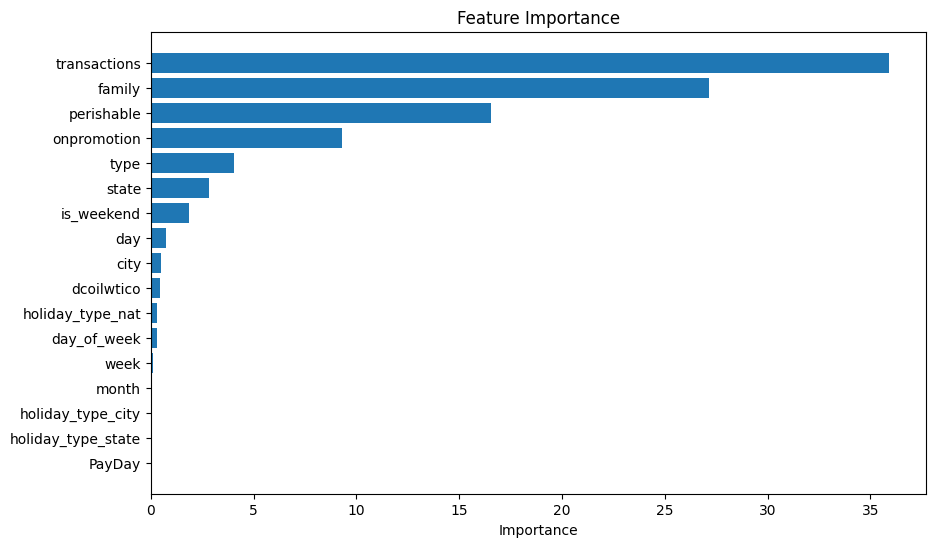

item score weights preparing...........
item score weights complted...........
training data error 0.7841708757178475
validation1 data error 0.790153184587664
validation2 data error 0.7855419045125126
model is saved and completed..........


In [6]:
print("train test split preparing...........")
# Example date range
start = pd.to_datetime('2017-01-01')
end = pd.to_datetime('2017-06-30')
train_ds = filter_dataframe_training_validation(X_2017,start,end)

start = pd.to_datetime('2017-07-01')
end = pd.to_datetime('2017-07-16')
val1_ds = filter_dataframe_training_validation(X_2017,start,end)

start = pd.to_datetime('2017-07-17')
end = pd.to_datetime('2017-08-02')
val2_ds = filter_dataframe_training_validation(X_2017,start,end)

print(train_ds.shape,val1_ds.shape,val2_ds.shape)

print(train_ds['date'].min(),
train_ds['date'].max(),
      val1_ds['date'].min(),
val1_ds['date'].max(),
      val2_ds['date'].min(),
val2_ds['date'].max())

# Drop 'store_nbr', 'item_nbr', and 'date' and other columns and assign the result to x_train
x_train = train_ds.drop(columns=['store_nbr', 'item_nbr', 'date','unit_sales',
                                 'description_nat','description_state','description_city',
                                 'Dayofyear','year'])
# Assign the 'unit_sales' column to y_train
y_train = train_ds[['unit_sales']]

# Drop 'store_nbr', 'item_nbr', and 'date' and other columns and assign the result to x_train
x_val1 = val1_ds.drop(columns=['store_nbr', 'item_nbr', 'date','unit_sales',
                                 'description_nat','description_state','description_city',
                                 'Dayofyear','year'])
# Assign the 'unit_sales' column to y_train
y_val1 = val1_ds[['unit_sales']]

# Drop 'store_nbr', 'item_nbr', and 'date' and other columns and assign the result to x_train
x_val2 = val2_ds.drop(columns=['store_nbr', 'item_nbr', 'date','unit_sales',
                                 'description_nat','description_state','description_city',
                                 'Dayofyear','year'])
# Assign the 'unit_sales' column to y_train
y_val2 = val2_ds[['unit_sales']]

print("train test split completed...........")
del train_ds,val1_ds,val2_ds
gc.collect()

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val1 shape:", x_val1.shape)
print("y_val1 shape:", y_val1.shape)
print("x_val2 shape:", x_val2.shape)
print("y_val2 shape:", y_val2.shape)



print("preparing for catboost modelling...........")

train_pred = []
val1_pred = []
val2_pred = []
cate_vars1 = ['onpromotion', 'day_of_week',
              'month','day','week','is_weekend','city','state','type',
              'family', 'perishable','holiday_type_city','holiday_type_state',
            'holiday_type_nat','PayDay']  # specify categorical features if any

# Additional hyperparameters
MAX_ROUNDS = 50
LEARNING_RATE = 0.7
DEPTH = 4
L2_LEAF_REG = 3
RANDOM_SEED = 42
SUBSAMPLE = 0.8
LOSS_FUNCTION = 'RMSE'

model = CatBoostRegressor(
    iterations=MAX_ROUNDS,
    learning_rate=LEARNING_RATE,
    depth=DEPTH,
    l2_leaf_reg=L2_LEAF_REG,
    random_seed=RANDOM_SEED,
    subsample=SUBSAMPLE,
    loss_function=LOSS_FUNCTION
)
model.fit(x_train,y_train,cat_features=cate_vars1)

train_pred.append(model.predict(
    x_train))
    
val1_pred.append(model.predict(
    x_val1))
    
val2_pred.append(model.predict(
    x_val2))

print("training is completed...........")


find_feature_importance(x_train)


# Compute arrays of item score weights for the items in the validation set (for which we will make predictions)
print("item score weights preparing...........")
y_train['weight'] = 1 + x_train['perishable'] * 0.25
y_val1['weight'] = 1 + x_val1['perishable'] * 0.25
y_val2['weight'] = 1 + x_val2['perishable'] * 0.25
del x_train,x_val1,x_val2
gc.collect()
print("item score weights complted...........")

print(f'training data error {calculate_score(train_pred,y_train[["unit_sales"]],y_train[["weight"]])}')
print(f'validation1 data error {calculate_score(val1_pred,y_val1[["unit_sales"]],y_val1[["weight"]])}')
print(f'validation2 data error {calculate_score(val2_pred,y_val2[["unit_sales"]],y_val2[["weight"]])}')


# Save the trained model
joblib_file = "catboost_model.pkl"
joblib.dump(model, joblib_file)
print("model is saved and completed..........")

**Inferencing**

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
!pip install pyunpack
!pip install patool
os.system('apt-get install p7zip')
from pyunpack import Archive
import shutil
from catboost import CatBoostRegressor
import joblib 


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        Archive(os.path.join(dirname, filename)).extractall('/kaggle/working/')
        print(os.path.join(dirname, filename))
        
##Read input data




#reading testing data test data has id (rownumber)|date|store_nbr|item_nbr|onpromotion
test_csv_file_path = './test.csv'
test_data = pd.read_csv(test_csv_file_path,usecols=[ 0,1, 2, 3, 4],
                     parse_dates=["date"]  )

inf_data = test_data.set_index(["store_nbr","item_nbr","date"])    
#MultiIndex: 3370464 entries, (1, 96995, Timestamp('2017-08-16 00:00:00')) 
#to (54, 2134244, Timestamp('2017-08-31 00:00:00'))
print("testing data is loaded")
print(test_data.shape)



#reading item data test data has item_nbr|family|class|perishable
item_csv_file_path = './items.csv'
item_data = pd.read_csv(item_csv_file_path).set_index("item_nbr")
print("item data is loaded")
print(item_data.shape)

#reading store data test data has store_nbr|city|state|type|cluster
store_csv_file_path = './stores.csv'
store_data = pd.read_csv(store_csv_file_path).set_index("store_nbr")
print("store data is loaded")
print(store_data.shape)

#reading oil data test data has date|unit
oil_csv_file_path = './oil.csv'
oil_data = pd.read_csv(oil_csv_file_path ,parse_dates=["date"],)
print("oil data is loaded")
print(oil_data.shape)


#reading transaction data test data has store_nbr|date|unit
transaction_csv_file_path = './transactions.csv'
trans_data = pd.read_csv(transaction_csv_file_path, parse_dates=["date"],)
print("trans data is loaded")
print(trans_data.shape)

#reading holiday data test data 
holiday_csv_file_path = './holidays_events.csv'
hol_data = pd.read_csv(holiday_csv_file_path, parse_dates=["date"],)
print("holiday data is loaded")
print(hol_data.shape)
      
print(f'testing data daterange.{find_min_max_daterange(test_data)}')
print(f'oil_data  daterange,{find_min_max_daterange(oil_data)}')
print(f'trans_data  daterange,{find_min_max_daterange(trans_data)}')      

print("promo data feature preparing...........")
test_data = promotion_data_preprocessing (test_data)
print("promo data missing value treatment & feature addition completed...........")
   
print("oil data preparing...........")
oil_2017 = filter_dataframe(oil_data,pd.Timestamp(2017,8,16))
del oil_data
gc.collect()
print("oil data preparation completed...........")
print(f'oil data daterange filtered to .{find_min_max_daterange(oil_2017)}')
test_data = oil_data_preprocessing(test_data, oil_2017)
print("oil data processing & feature addition completed..........")

#impute 2017,7,16 to 2017,7,31 data as 2017,8,16 to 2017,8,31 data
print("transaction data preparing...........")
trans_test_lastmon =trans_data.loc[(pd.Timestamp(2017,7,1)<=trans_data.date) & (trans_data.date <=pd.Timestamp(2017,7,31))]
del trans_data
gc.collect()
# trans_test_lastmon.head()

# Assuming trans_test_lastmon is your DataFrame
trans_test_lastmon['date'] = trans_test_lastmon['date'] + pd.DateOffset(months=1)

# Merge test_data with trans_test_lastmon
merged_data = pd.merge(test_data, trans_test_lastmon, how='left', on=['date', 'store_nbr'])
# Update the transactions column in test_data
test_data['transactions'] = merged_data['transactions']
print("trans data processing & feature addition completed..........")


print("store and item  data preparing...........")
test_data = test_data.set_index(
    ["store_nbr", "item_nbr"])[["date","onpromotion","dcoilwtico","transactions"]]
items = item_data.reindex(test_data.index.get_level_values(1))
stores = store_data.reindex(test_data.index.get_level_values(0))
print (items.shape,stores.shape,test_data.shape)

test_data = pd.concat([test_data.reset_index(drop=False),
                     stores[["city","state","type"]].reset_index(drop=True), 
                     items[["family","perishable"]].reset_index(drop=True)], axis=1)
print("store/item data  preprocessing & feature addition completed...........")
del merged_data,oil_2017,trans_test_lastmon
gc.collect()

test_data = create_date_features(test_data)
print("date related feature addition completed...........")

print("holiday  data preparing...........")
hol_data= filter_dataframe(hol_data,pd.Timestamp(2017,8,16))
test_data = create_holiday_features (test_data,hol_data)
print("holiday related feature addition completed...........")

test_data = create_paydate_feature(test_data)
print("paydate related feature addition completed...........")
test_data = custom_label_encoding(test_data)
print("label encoding features  addition completed...........")
test_data.columns[test_data.isnull().any()]   # these columns have missing values


print(test_data['date'].min(),
test_data['date'].max())


# Drop 'store_nbr', 'item_nbr', and 'date' columns and assign the result to x_train
x_inf = test_data.drop(columns=['store_nbr', 'item_nbr', 'date',
                                 'description_nat','description_state','description_city',
                                 'Dayofyear','year'])

print("x_inf shape:", x_inf.shape)
print("preparing for catboost inferencing...........")

inf_pred = []
# Load the trained model
model = joblib.load('catboost_model.pkl')


inf_pred.append(model.predict(
    x_inf))

print("inferencing is completed...........")



#inf_pred is an array, len(inf_pred)=1 , transpose it to the size of x_inf 
y_inf = np.array(inf_pred).transpose()
inf_df  = pd.DataFrame(y_inf, index = inf_data.index).rename({0:"unit_sales"}, axis=1)

print(inf_df.shape,inf_data.shape )



final = inf_data[["id"]].join(inf_df,how='left').fillna(0)
final["unit_sales"] =np.round(np.clip(np.expm1(final["unit_sales"]),0,1000),1)
final.to_csv('final_submission.csv', index=None)
print("final submission file created")
print ("DONE")




Reading package lists...
Building dependency tree...
Reading state information...
p7zip is already the newest version (16.02+dfsg-7build1).
0 upgraded, 0 newly installed, 0 to remove and 64 not upgraded.
/kaggle/input/favorita-grocery-sales-forecasting/test.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/stores.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/train.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv.7z
testing data is loaded
(3370464, 5)
item data is loaded
(4100, 3)
store data is loaded
(54, 4)
oil data is loaded
(1218, 2)
trans data is loaded
(83488, 3)
holiday data is loaded
(350, 6)
testing data daterange.(Timestamp('2017-08-16 00:00:00'), Timestamp('2017-08-31 00:00